In [4]:
pip install -r requirements-inv.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.1/27.1 MB 32.1 MB/s eta 0:00:0000:0100:01


Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import standard libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import sklearn functions and classes
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve, validation_curve, KFold
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, make_scorer, explained_variance_score
)

# Import CatBoost
from catboost import CatBoostRegressor

# For defining parameter distributions
from scipy.stats import randint, uniform

# Suppress warnings
warnings.filterwarnings('ignore')

In [7]:
# Load the cleaned DataFrame from the CSV file
df_pca_combined = pd.read_csv('df_pca_combined.csv')

# Utility Functions

In [6]:
# Utility functions
def prepare_data(df, target_column):  
    # Prepare data for machine learning
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adjusted_r2_score(y_true, y_pred, X):
    n = len(y_true)
    p = X.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def evaluate_model(y_true, y_pred, X, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2_score(y_true, y_pred, X)
    
    metrics = {
        'Dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'Training Time': None  # Placeholder, will be updated in model scripts
    }
    return metrics

def plot_learning_curve(model, X_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_validation_curve(model, X_train, y_train, param_name, param_range):
    train_scores, val_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(param_range, train_scores_mean, 'o-', label="Training score")
    plt.plot(param_range, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title(f"Validation Curve for {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals)
    plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid()
    plt.show()

def plot_prediction_vs_actual(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Prediction vs Actual")
    plt.grid()
    plt.show()

def save_results_to_csv(results, filename='model_results.csv'):
    df_results = pd.DataFrame(results)
    df_results.to_csv(filename, index=False)

def plot_metrics(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df.melt(id_vars='Dataset', value_vars=['RMSE', 'MAE', 'R²']), x='variable', y='value', hue='Dataset', ax=ax)
    ax.set_title('Model Performance Comparison', fontsize=20)
    ax.set_ylabel('Score', fontsize=15)
    ax.set_xlabel('Metrics', fontsize=15)
    ax.legend(title='Model', title_fontsize='13', fontsize='11')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def plot_timing(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df, x='Dataset', y='Training Time', palette='viridis', ax=ax)
    ax.set_title('Model Training Time Comparison', fontsize=20)
    ax.set_ylabel('Time (seconds)', fontsize=15)
    ax.set_xlabel('Model', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def error_analysis(y_true, predictions, model_name):
    error = y_true - predictions
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(error, bins=50, kde=True, color='coral', ax=ax)
    ax.set_title(f'Prediction Error Distribution for {model_name}', fontsize=20)
    ax.set_xlabel('Prediction Error', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

# CatBoost

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'Dataset': 'CatBoost (Training)', 'MSE': 0.010462217365069757, 'RMSE': 0.1022849811314924, 'MAE': 0.07659584572722312, 'MAPE': 37.765154073446325, 'R²': 0.9894576352222747, 'Adjusted R²': 0.9893126463387937, 'Training Time': 36.27528691291809}
{'Dataset': 'CatBoost (Validation)', 'MSE': 0.01947935678495522, 'RMSE': 0.13956846629864217, 'MAE': 0.09710686974338771, 'MAPE': 44.84700565588295, 'R²': 0.9806582337463968, 'Adjusted R²': 0.9798371955054276, 'Training Time': None}
{'Dataset': 'CatBoost (Test)', 'MSE': 0.01820256370835653, 'RMSE': 0.13491687703307, 'MAE': 0.09638841930268623, 'MAPE': 40.886260379721854, 'R²': 0.9822265772060599, 'Adjusted R²': 0.9814727289309498, 'Training Time': None}

Additional Metrics (Not Included in Inter-Model Comparison):
Cross-Validation RMSE: 0.14279050169374663
Cross-Validation MAE: 0.10083303624707245
Cross-Validation MAPE: 49.429252477459876
Cross-Validation R²: 0.9794449016201373


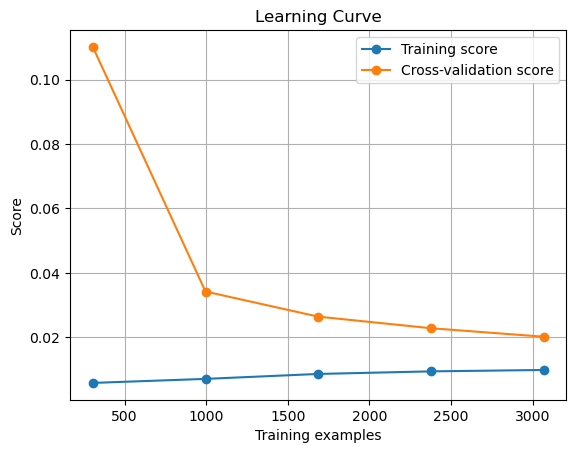

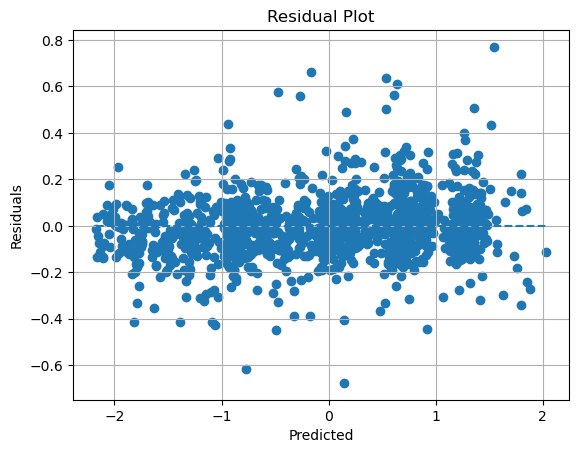

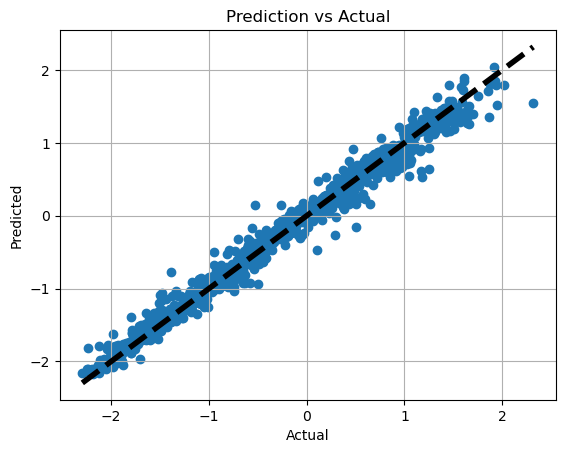

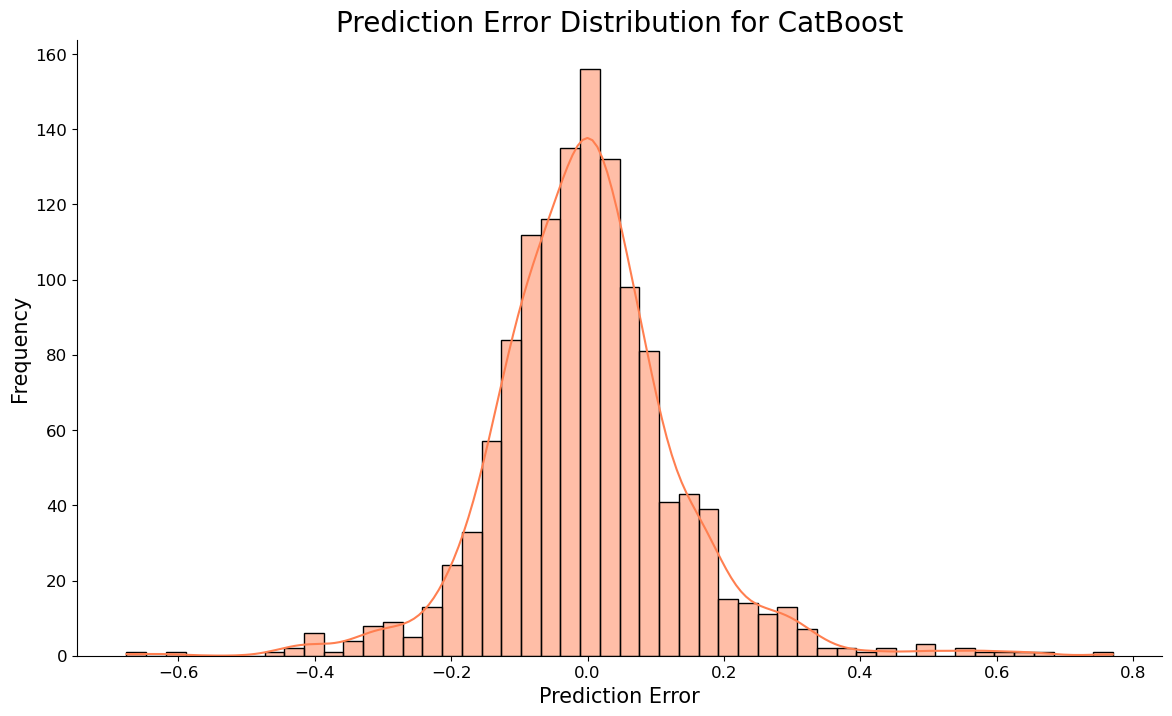

In [8]:
# Define function to run the CatBoost model with separated metrics for inter-model comparison
def run_catboost(df, target_column='Weekly_Sales', results_filename='catboost_results.csv'):
    df_catboost = df.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_catboost, target_column)
    
    # Define the parameter distribution for hyperparameter tuning
    param_dist = {
        'iterations': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }
    
    model = CatBoostRegressor(random_state=42, silent=True)
    
    # RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        verbose=1, 
        n_jobs=-1, 
        random_state=42
    )
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    best_model = random_search.best_estimator_
    
    # Evaluate with cross-validation (5-fold)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_mse = -np.mean(cv_scores)
    cv_rmse = np.sqrt(cv_mse)
    cv_mae = -np.mean(cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error'))
    cv_mape = -np.mean(cross_val_score(best_model, X_train, y_train, cv=cv, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False)))
    cv_r2 = np.mean(cross_val_score(best_model, X_train, y_train, cv=cv, scoring='r2'))

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    # Evaluate metrics (Inter-model comparison metrics)
    catboost_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'CatBoost (Training)')
    catboost_train_metrics['Training Time'] = training_time  # Update training time
    catboost_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'CatBoost (Validation)')
    catboost_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'CatBoost (Test)')

    # Create results list for inter-model comparison metrics
    results = [
        catboost_train_metrics,
        catboost_val_metrics,
        catboost_test_metrics
    ]

    # Save inter-model comparison results to CSV
    save_results_to_csv(results, results_filename)
    
    # Print inter-model comparison metrics
    for result in results:
        print(result)

    # Print additional metrics separately (Not included in inter-model comparison)
    print("\nAdditional Metrics (Not Included in Inter-Model Comparison):")
    print(f"Cross-Validation RMSE: {cv_rmse}")
    print(f"Cross-Validation MAE: {cv_mae}")
    print(f"Cross-Validation MAPE: {cv_mape}")
    print(f"Cross-Validation R²: {cv_r2}")

    # Plot learning curve
    plot_learning_curve(best_model, X_train, y_train)

    # Plot residuals
    plot_residuals(y_test, y_test_pred)

    # Plot predicted vs actual values
    plot_prediction_vs_actual(y_test, y_test_pred)

    # Perform error analysis
    error_analysis(y_test, y_test_pred, 'CatBoost')

# Run the CatBoost model
run_catboost(df_pca_combined)